# Transfer Learning with Tensorflow Part 1: Feature Extraction

  TensorFlow ile Öğrenimi Aktarın Bölüm 1: Özellik Çıkarımı Sıfırdan bir grup evrişimli sinir ağı oluşturduk ve hepsi öğreniyor gibi görünüyor, ancak hala iyileştirilecek çok yer var. Model(ler)imizi geliştirmek için, farklı konfigürasyonlar deneyerek, daha fazla katman ekleyerek, öğrenme oranını değiştirerek, katman başına nöron sayısını ayarlayarak ve daha fazlasını yaparak biraz zaman geçirebiliriz. Ancak, bunu yapmak çok zaman alıcıdır. Neyse ki, zaman kazanmak için kullanabileceğimiz bir teknik var. Buna transfer öğrenme denir, başka bir deyişle, başka bir modelin başka bir problemden öğrendiği kalıpları (ağırlıklar da denir) alıp kendi problemimiz için kullanırız. Transfer öğrenmeyi kullanmanın iki ana faydası vardır: Bizimkine benzer problemler üzerinde çalıştığı kanıtlanmış mevcut bir sinir ağı mimarisinden faydalanabilir. Bizimkine benzer veriler üzerinde kalıpları zaten öğrenmiş çalışan bir sinir ağı mimarisinden yararlanabilir. Bu genellikle daha az özel veriyle mükemmel sonuçlar elde edilmesini sağlar. Bunun anlamı, kendi sinir ağı mimarilerimizi elle oluşturmak veya sıfırdan inşa etmek yerine, başkaları için işe yaramış modelleri kullanabiliriz. Ve kendi veri kümelerimizde sıfırdan kendi modellerimizi eğitmek yerine, bir modelin ImageNet (farklı nesnelerin milyonlarca görüntüsü) gibi veri kümelerinden öğrendiği kalıpları alıp kendi temelimiz olarak kullanabiliriz. Bunu yapmak genellikle daha az veriyle harika sonuçlar alınmasını sağlar. Önümüzdeki birkaç not defterinde, öğrenmeyi transfer etmenin gücünü iş başında göreceğiz.

In [ ]:
# Are we using a GPU?
!nvidia-smi

Sat May 27 10:36:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Donwloding and becoming one with the data

In [ ]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-05-27 10:36:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.128, 74.125.69.128, 64.233.183.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   101MB/s    in 1.6s    

2023-05-27 10:36:59 (101 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder
import os

# Walk through 10 percent data directory and list number of files
for dirpath,dirnames,filnames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filnames)} images in '{dirpath}'.") 

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/gri

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import matplotlib.image as mpimg

In [ ]:
def plot_images(target_dir,target_class):
  target_folder = target_dir + target_class
  random_images = random.sample(os.listdir(target_folder),1)
  img = mpimg.imread(target_folder + '/' + random_images[0])# mpimg.imread fonksiyonu hedef dosyadaki resmi array formatına çevirir
  plt.imshow(img) 
  plt.axis(False)
  plt.title(target_class) 

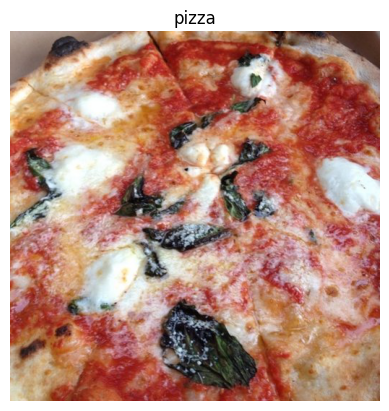

In [ ]:
plot_images('10_food_classes_10_percent/train/',
            'pizza')

# Creating data loaders (preparing the data)

Wel'll use the ImageDataGenerator class to load in our images in batches

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_dategen = ImageDataGenerator(rescale=1/255.)
print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')
test_data = test_dategen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode = 'categorical')

Training images:
Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains) Geri aramalar model eğitilirken çalıştırılacak şeylerdir
Bir model oluşturmadan önce, aşina olacağımız önemli bir kavram var çünkü bu, gelecekteki model oluşturma deneylerimizde önemli bir rol oynayacak. Ve bu kavram geri aramalardır. Geri aramalar, eğitim sırasında veya sonrasında gerçekleştirilmek üzere modellerinize ekleyebileceğiniz ekstra işlevlerdir. En popüler geri aramalardan bazıları şunları içerir: TensorBoard ile deney izleme - birden fazla modelin performansını günlüğe kaydedin ve ardından bu modelleri TensorBoard'da (sinir ağı parametrelerini incelemek için bir pano) görsel bir şekilde görüntüleyin ve karşılaştırın. Verileriniz üzerinde farklı modellerin sonuçlarını karşılaştırmak faydalıdır. Model kontrol noktası - modelinizi çalışırken kaydedin, böylece gerekirse eğitimi durdurabilir ve kaldığınız yerden devam etmek için geri dönebilirsiniz. Eğitim uzun sürüyorsa ve bir oturuşta yapılamıyorsa faydalıdır. Erken durdurma - model eğitiminizi istediğiniz bir süre bırakın ve iyileşme durduğunda otomatik olarak eğitimini durdurun. Büyük bir veri kümeniz olduğunda ve eğitimin ne kadar süreceğini bilmediğinizde faydalıdır. Bu fazla mesailerin her birini inceleyeceğiz ancak bu not defteri için TensorBoard geri aramasının nasıl kullanılabileceğini göreceğiz. TensorBoard geri aramasına tf.keras.callbacks.TensorBoard() kullanılarak erişilebilir. Ana işlevi, bir modelin eğitim performansı ölçümlerini belirtilen bir log_dir'e kaydetmektir. Varsayılan olarak, günlükler her çağda update_freq='epoch' parametresi kullanılarak kaydedilir. Model performansının çok sık izlenmesi model eğitimini yavaşlatabileceğinden, bu iyi bir varsayılandır. TensorBoard kullanarak modelleme deneylerimizi izlemek için, bizim için bir TensorBoard geri araması oluşturan bir fonksiyon oluşturalım. 🔑 Not: TensorBoard geri arama oluşturmak için bir işlev oluşturuyoruz çünkü daha sonra göreceğimiz gibi, her modelin kendi TensorBoard geri arama örneğine ihtiyacı var (böylece işlev her çalıştırıldığında yeni bir tane oluşturacaktır).

## Calbacks(Geri çağırım) Geri çağırmalar eğitim ve değerlendirme sırasında modellerimize yararlı işlevler ekleyebilen araçlardır

In [ ]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback
# Bu kod, TensorBoard geriçağırısını oluşturan ve her bir model için yeni bir TensorBoard geriçağırısı oluşturmak için kullanılan bir işlevi tanımlar.
#TensorBoard, TensorFlow'un sağladığı bir görselleştirme aracıdır ve modelin eğitimi sırasında metriklerin, kayıp değerlerinin, grafiklerin ve diğer ilgili bilgilerin izlenmesini sağlar.

# İşlevin parametreleri aşağıdaki gibidir:

# dir_name: TensorBoard log dosyalarının kaydedileceği ana dizin adı. Bu, her bir modelin log dosyalarının ayrı bir klasör içinde saklanmasını sağlar.
# experiment_name: Her bir modelin log dosyalarının saklanacağı deney adı. Bu, log dosyalarının daha iyi bir düzen ve takip sağlaması için kullanılır.
# İşlevin çalışma mantığı şu adımları izler:

# Şu anki tarih ve saat bilgisini kullanarak, her bir model için yeni bir log dizini oluşturulur. Bu, log dosyalarının zaman damgası içeren bir klasörde saklanmasını sağlar.
# Oluşturulan log dizini, TensorBoard geriçağırısının log_dir parametresine atanır.
# Konsola, TensorBoard log dosyalarının hangi dizine kaydedildiği bilgisini yazdırır.
# Oluşturulan TensorBoard geriçağırısı tensorboard_callback olarak döndürülür.
# Bu işlevi kullanarak her bir model için ayrı bir TensorBoard geriçağırısı oluşturabilirsiniz. Bu geriçağırıları, modeli eğitirken callbacks argümanına ekleyerek TensorBoard log dosyalarını kaydedebilir ve daha 
#sonra TensorBoard arayüzünde modelin performansını izleyebilirsiniz.

## Creating models using TensorFlow Hub

Geçmişte sıfırdan katman katman kendi modellerimizi oluşturmak için tensorflow kullandık

Şimdide benzer bir işlem yapacağız ancak model katmanlarımızın çoğu TensorFlow Hub'dan gelecek 

https://tfhub.dev/ ile önceden eğitilmiş modelere erişebiliyoruz


Akış sayfasına göz atarak görüntü sınıflandırması için özelik vektörü bağlantısini modeli bulduk:https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
# Aşağıda 2 modeli kaşılaştıralım 
resnet_url ="https://tfhub.dev/tensorflow/resnet_50/feature_vector/1"

efficientnet = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [ ]:
from keras.api._v2.keras import activations
# Let's make a create_model() function to create a model from a URL
def create_model(model_url,num_classes=10):


  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer Daha önce eğitilmiş olan modeli indireceğiz
  feature_extractor_layer = hub.KerasLayer(model_url,# Bu kod, TensorFlow Hub kütüphanesini kullanarak bir modelin özellik çıkarıcı katmanını oluşturur. Özellik çıkarıcı katman, 
                                           #önceden eğitilmiş bir modelin içinden gelen verilere dayalı olarak öznitelikleri çıkaran bir bileşendir.
                                           trainable=False, # freeze the underlying patterns Bu parametre önceden eğitilmiş modelin eğitilebilir olup olmadığını belirler 
                                           # trainable = False olduğu zaman model önceden öğrendiği kalıpları kulanacağı anlamaına gelir
                                           # False olarak ayarlandığı zaman modelin öğrenilebilir ağırlıklarını dondurur ve eğitim sırasında güncellenmez
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape Giriş görüntülerinin şekli belirtilir.
  
  # Bu kod, transfer öğrenmenin ilk aşamasını gerçekleştirmek için kullanılır. Transfer öğrenme, bir görevde önceden eğitilmiş bir modelin özelliklerini kullanarak başka bir görevi çözmek için kullanılan bir yöntemdir. 
  #İlk aşamada, önceden eğitilmiş modelin özellik çıkarıcı katmanı kullanılarak giriş görüntülerinden öznitelikler çıkarılır.

  # Bu aşamada, hub.KerasLayer ile önceden eğitilmiş bir modelin özellik çıkarıcı katmanı oluşturulur. trainable=False olarak ayarlanarak, önceden eğitilmiş modelin ağırlıkları dondurulur ve eğitim sırasında güncellenmez. 
  #Bu, önceden öğrenilen modelin içerdiği kalıpların korunmasını sağlar.

  # İkinci aşamada, önceden eğitilmiş özellik çıkarıcı katman üzerine bir veya daha fazla tam bağlantılı (fully connected) katman eklenir ve bu katmanlar, önceden eğitilmiş özelliklerden elde edilen öznitelikleri kullanarak 
  #öğrenme yapar. Bu yeni eklenen katmanlar, transfer öğrenme görevine özgüdür ve önceden eğitilmiş modelin özelliklerini hedef görev için uyarlamayı sağlar.

  # Transfer öğrenme, genellikle sınıflandırma veya regresyon gibi görevlerde kullanılır. Önceden eğitilmiş bir modelin özellik çıkarıcı katmanı, genel nesne özelliklerini yakalamada iyi bir performans gösterir
  # ve daha az veriyle yeni bir görev için daha iyi bir başlangıç noktası sağlar.

  # Bu nedenle, transfer öğrenmenin ilk aşamasında önceden eğitilmiş bir modelin özellik çıkarıcı katmanını kullanarak öznitelikleri çıkarmak, daha sonra bu özellikleri hedef görev için öğrenme yapmak amacıyla kullanılacak 
  #ek katmanları eklemek için bir başlangıç noktası oluşturur. 

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,# use the feature extraction layer as the base  Özelik çıkarma katmanını kulandık 
      layers.Dense(num_classes,activation='softmax',name = 'output_layer')

  ])
  return model
  # tf.keras.Sequential ile bir model oluşturulur. Bu model, önceden oluşturduğunuz feature_extractor_layer (özellik çıkarıcı katman) ile başlar. Bu katman, önceden eğitilmiş modelin belirli bir katmanının çıktılarını 
  #temsil eder ve özellik çıkarımı yapar.

  # Daha sonra, layers.Dense ile kendi çıktı katmanınız (output_layer) oluşturulur. Bu çıktı katmanı, belirli bir sayıda sınıf için aktivasyon fonksiyonu olarak softmax kullanarak sınıflandırma yapar. num_classes, veri 
  #kümenizdeki sınıf sayısını temsil eder.

  # Sonuç olarak, model değişkenine atanan bu tf.keras.Sequential modeli, özellik çıkarıcı katmanı temel alarak önceden eğitilmiş modelin çıktılarını kullanır ve ardından kendi çıktı katmanını ekleyerek sınıflandırma yapar.

  # Bu şekilde, transfer öğrenme modeli oluşturulmuş olur. Önceden eğitilmiş modelin özelliklerini kullanarak yeni bir görev için başlangıç noktası olarak öğrenme yapabilir ve kendi çıktı katmanınızı ekleyerek hedef görevi 
  #çözebilirsiniz.                             

In [ ]:
# Create Resnet model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

In [ ]:
train_data_10_percent.num_classes

10

In [ ]:
# Compile the model
resnet_model.compile(loss='categorical_crossentropy',
                      optimizer = tf.keras.optimizers.Adam(),
                      metrics=['accuracy'])

In [ ]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230527-103717
Epoch 1/5
24/24 [==============================] - 35s 894ms/step - loss: 2.0311 - accuracy: 0.3453 - val_loss: 1.2143 - val_accuracy: 0.5860
Epoch 2/5
24/24 [==============================] - 19s 793ms/step - loss: 0.9201 - accuracy: 0.7107 - val_loss: 0.8439 - val_accuracy: 0.7268
Epoch 3/5
24/24 [==============================] - 18s 775ms/step - loss: 0.5952 - accuracy: 0.8373 - val_loss: 0.6747 - val_accuracy: 0.7856
Epoch 4/5
24/24 [==============================] - 19s 803ms/step - loss: 0.4566 - accuracy: 0.8773 - val_loss: 0.6023 - val_accuracy: 0.8160
Epoch 5/5
24/24 [==============================] - 18s 774ms/step - loss: 0.3598 - accuracy: 0.9133 - val_loss: 0.5706 - val_accuracy: 0.8204


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23561152  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,581,642
Trainable params: 20,490
Non-trainable params: 23,561,152
_________________________________________________________________


In [ ]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

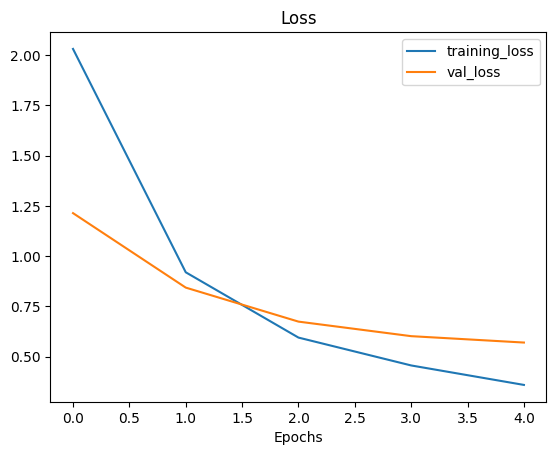

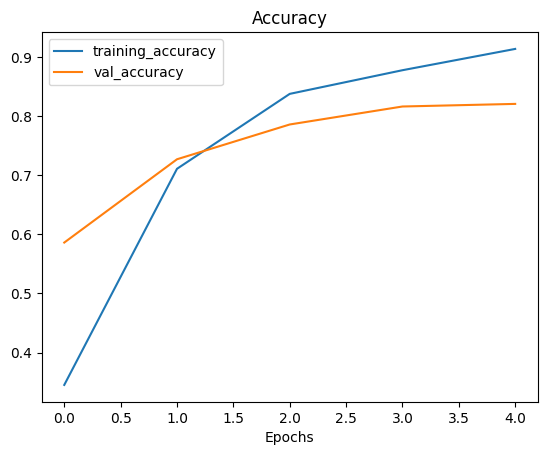

In [ ]:
plot_loss_curves(resnet_history)

In [ ]:
# Resnet summary
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23561152  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,581,642
Trainable params: 20,490
Non-trainable params: 23,561,152
_________________________________________________________________


TensorFlow Hub'ın gücünü burada görebilirsiniz. Özellik çıkarma katmanı, modelin ImageNet veri kümesinde önceden öğrendiği kalıplar olan 23.564.800 parametreye sahiptir. eğitilebilir=False olarak ayarladığımız için, bu kalıplar eğitim sırasında donmuş (eğitilemez) olarak kalır. Bu, eğitim sırasında modelin çıktı katmanındaki 20.490 parametreyi veri kümemize uyacak şekilde güncellediği anlamına gelir. Tamam, bir ResNetV250 modelini eğittik, aynısını EfficientNetB0 modeliyle yapma zamanı. Kurulum, create_model() işlevindeki model_url parametresi ve işlevdeki deney_adı parametresi dışında öncekiyle tamamen aynı olacaktır.

In [ ]:
# Create a model
efficientnet_model = create_model(model_url=efficientnet,
                                  num_classes = train_data_10_percent.num_classes)
# Compile Efficientnet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])
# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20230527-103931
Epoch 1/5
24/24 [==============================] - 31s 857ms/step - loss: 1.8306 - accuracy: 0.4640 - val_loss: 1.2905 - val_accuracy: 0.7268
Epoch 2/5
24/24 [==============================] - 18s 764ms/step - loss: 1.0323 - accuracy: 0.7840 - val_loss: 0.8665 - val_accuracy: 0.8148
Epoch 3/5
24/24 [==============================] - 18s 749ms/step - loss: 0.7426 - accuracy: 0.8413 - val_loss: 0.6964 - val_accuracy: 0.8380
Epoch 4/5
24/24 [==============================] - 17s 736ms/step - loss: 0.5954 - accuracy: 0.8707 - val_loss: 0.6120 - val_accuracy: 0.8524
Epoch 5/5
24/24 [==============================] - 17s 733ms/step - loss: 0.5045 - accuracy: 0.8907 - val_loss: 0.5583 - val_accuracy: 0.8568


In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


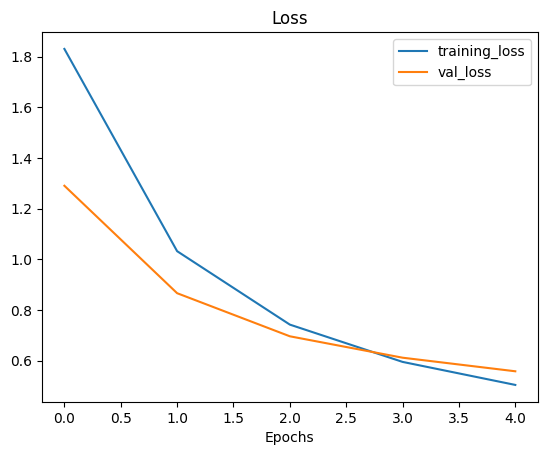

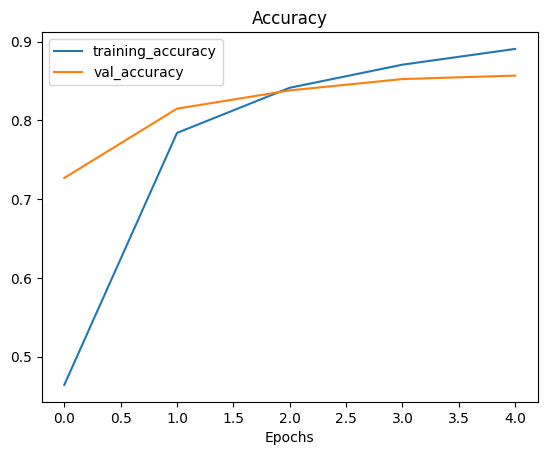

In [ ]:
plot_loss_curves(efficientnet_history)

# Comparing models using TensorBoard

Doğruluk puanlarına bakarak iki modelimizin performansını zaten karşılaştırmış olmamıza rağmen, TensorBoard Alright kullanarak modelleri karşılaştırma. Peki ya ikiden fazla modeliniz varsa? TensorBoard (Google Colab'da önceden yüklenmiş) gibi bir deney izleme aracının devreye girdiği yer burasıdır. İşin iyi yanı, bir TensorBoard geri araması kurduğumuz için, modelimizin tüm eğitim günlükleri otomatik olarak kaydedilmiştir. Bunları görselleştirmek için sonuçları TensorBoard.dev'e yükleyebiliriz. Sonuçlarınızı TensorBoard.dev'e yüklemek, birden çok farklı modelleme deneyini izlemenizi ve paylaşmanızı sağlar. Sonuçlarınızı birisine göstermeniz gerekirse, onlara TensorBoard.dev'inizin yanı sıra beraberindeki Colab not defterine bir bağlantı gönderebilirsiniz. 🔑 Not: Bu deneyler herkese açıktır, hassas veriler yüklemeyin. Gerekirse denemeleri silebilirsiniz.

Deneyleri TensorBoard'a yükleme Bir dizi TensorFlow günlüğünü TensorBoard'a yüklemek için şu komutu kullanabiliriz: Upload TensorBoard dev record !tensorboard dev upload --logdir .

* --logdir is the target upload directory

* --name is the name of the experiment

* --description is a brief description of the experiment

* --one_shot exits the TensorBoard uploader once uploading is finished


--logdir hedef yükleme dizini --name deneyin adıdır --description, deneyin kısa bir açıklamasıdır --one_shot, yükleme bittiğinde TensorBoard yükleyicisinden çıkar

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2023-05-27 10:41:28.312376: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   QNZQ-NKTS



New experiment created. View your TensorBoard at: https://tensorboard.dev/expe

Our TensorBoard are uploaded publicaly here :https://tensorboard.dev/experiment/1phxv8wqT8C2muaQzkQ19A/

In [ ]:
# Check out what TensorBoard experiments you have
!tensorboard dev list 

2023-05-27 10:50:34.296441: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/1phxv8wqT8C2muaQzkQ19A/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   1phxv8wqT8C2muaQzkQ19A
	Created              2023-05-27 10:42:52 (7 minutes ago)
	Updated              2023-05-27 10:42:54 (7 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  6663763
Total: 1 experiment(s)


# Deleting experiments from TensorBoard

In [ ]:
# Dele an experiment
!tensorboard dev delete --experiment_id 1phxv8wqT8C2muaQzkQ19A

2023-05-27 10:54:39.355305: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Deleted experiment 1phxv8wqT8C2muaQzkQ19A.


In [ ]:
!tensorboard dev list 

2023-05-27 10:54:48.437399: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No experiments. Use `tensorboard dev upload` to get started.
